In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [2]:
train_file_path = 'train.csv'
test_file_path = 'test.csv'
train_raw = pd.read_csv(train_file_path)
test_raw = pd.read_csv(test_file_path)

In [3]:
column_names = ['date', 'in_out', 'latitude', 'longitude',
                '6~7_ride', '7~8_ride', '8~9_ride',
                '9~10_ride', '10~11_ride', '11~12_ride',
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
                '9~10_takeoff', '10~11_takeoff', '18~20_ride']

raw_dataset = pd.read_csv(train_file_path, usecols=column_names,
                          na_values='?', skipinitialspace=True)

dataset = raw_dataset.copy()

dataset.tail()

,date,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,18~20_ride
415418,2019-09-30,시내,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,2019-09-30,시내,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,2019-09-30,시내,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
415421,2019-09-30,시내,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,2019-09-30,시내,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0


In [4]:
# monday = 0, sunday = 6
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['weekday'] = dataset['date'].dt.weekday
dataset.tail()

,date,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,18~20_ride,weekday
415418,2019-09-30,시내,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
415419,2019-09-30,시내,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
415420,2019-09-30,시내,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
415421,2019-09-30,시내,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
415422,2019-09-30,시내,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0


In [5]:
# 주말 데이터
dataset['weekend'] = (dataset['weekday'] >= 5).astype(float)

In [6]:
# 휴일 데이터
holidays = pd.to_datetime(['2019-09-12', '2019-09-13', '2019-09-14', 
                           '2019-10-03', '2019-10-09'])
dataset['holidays'] = dataset['date'].isin(holidays)*1.0

In [7]:
# 요일 one hot encoding
dataset['mon'] = (dataset['weekday'] == 0)*1.0
dataset['tue'] = (dataset['weekday'] == 1)*1.0
dataset['wed'] = (dataset['weekday'] == 2)*1.0
dataset['thu'] = (dataset['weekday'] == 3)*1.0
dataset['fri'] = (dataset['weekday'] == 4)*1.0
dataset['sat'] = (dataset['weekday'] == 5)*1.0
dataset['sun'] = (dataset['weekday'] == 6)*1.0

In [8]:
# 필요 없는 칼럼 지우기
dataset.drop(['date', 'weekday'], 1, inplace=True)
dataset.tail()

,in_out,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,...,18~20_ride,weekend,holidays,mon,tue,wed,thu,fri,sat,sun
415418,시내,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,시내,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,시내,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415421,시내,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,시내,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
in_out = dataset.pop('in_out')
dataset['in'] = (in_out == '시내')*1.0
dataset['out'] = (in_out == '시외')*1.0
dataset.tail()

,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,...,holidays,mon,tue,wed,thu,fri,sat,sun,in,out
415418,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
415419,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
415420,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
415421,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
415422,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
import pyresample
import numpy as np

In [11]:
lon = np.linspace(dataset['longitude'].min(), dataset['longitude'].max(), 50)
lat = np.linspace(dataset['latitude'].min(), dataset['latitude'].max(), 50)

# 제일 거리가 가까운 grid 인덱스 찾기
def geo_idx(dd, dd_array):
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

In [12]:
lon, lat

(array([126.16504   , 126.18137939, 126.19771878, 126.21405816,
        126.23039755, 126.24673694, 126.26307633, 126.27941571,
        126.2957551 , 126.31209449, 126.32843388, 126.34477327,
        126.36111265, 126.37745204, 126.39379143, 126.41013082,
        126.4264702 , 126.44280959, 126.45914898, 126.47548837,
        126.49182776, 126.50816714, 126.52450653, 126.54084592,
        126.55718531, 126.57352469, 126.58986408, 126.60620347,
        126.62254286, 126.63888224, 126.65522163, 126.67156102,
        126.68790041, 126.7042398 , 126.72057918, 126.73691857,
        126.75325796, 126.76959735, 126.78593673, 126.80227612,
        126.81861551, 126.8349549 , 126.85129429, 126.86763367,
        126.88397306, 126.90031245, 126.91665184, 126.93299122,
        126.94933061, 126.96567   ]),
 array([33.20835   , 33.22376408, 33.23917816, 33.25459224, 33.27000633,
        33.28542041, 33.30083449, 33.31624857, 33.33166265, 33.34707673,
        33.36249082, 33.3779049 , 33.39331898, 3

In [13]:
dataset['longitude'][0]

126.49373

In [14]:
geo_idx(dataset['longitude'][0], lon)

20

In [15]:
dataset['grid_lon'] = dataset['longitude'].map(lambda x: geo_idx(x, lon))
dataset['grid_lat'] = dataset['latitude'].map(lambda x: geo_idx(x, lat))
dataset.tail()

,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,...,tue,wed,thu,fri,sat,sun,in,out,grid_lon,grid_lat
415418,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,13
415419,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21,19
415420,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6,1
415421,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9,17
415422,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,21,3


In [16]:
dataset = pd.get_dummies(dataset, columns=['grid_lon', 'grid_lat'])
dataset.tail()

,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,...,grid_lat_17,grid_lat_18,grid_lat_19,grid_lat_20,grid_lat_21,grid_lat_22,grid_lat_23,grid_lat_47,grid_lat_48,grid_lat_49
415418,33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
415419,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
415420,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
415421,33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
415422,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
dataset.drop(['latitude', 'longitude'], 1, inplace=True)
dataset.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,grid_lat_17,grid_lat_18,grid_lat_19,grid_lat_20,grid_lat_21,grid_lat_22,grid_lat_23,grid_lat_47,grid_lat_48,grid_lat_49
415418,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
415419,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
415420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
415421,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
415422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
dataset = dataset.astype('float32')
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('18~20_ride')
test_labels = test_dataset.pop('18~20_ride')

In [19]:
numeric_columns = [
    '6~7_ride', '7~8_ride', '8~9_ride',
    '9~10_ride', '10~11_ride', '11~12_ride',
    '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
    '9~10_takeoff', '10~11_takeoff'
]

categorical_columns = train_dataset.columns.difference(numeric_columns)
categorical_columns

Index(['fri', 'grid_lat_0', 'grid_lat_1', 'grid_lat_10', 'grid_lat_11',
       'grid_lat_12', 'grid_lat_13', 'grid_lat_14', 'grid_lat_15',
       'grid_lat_16', 'grid_lat_17', 'grid_lat_18', 'grid_lat_19',
       'grid_lat_2', 'grid_lat_20', 'grid_lat_21', 'grid_lat_22',
       'grid_lat_23', 'grid_lat_3', 'grid_lat_4', 'grid_lat_47', 'grid_lat_48',
       'grid_lat_49', 'grid_lat_5', 'grid_lat_6', 'grid_lat_7', 'grid_lat_8',
       'grid_lat_9', 'grid_lon_0', 'grid_lon_1', 'grid_lon_10', 'grid_lon_11',
       'grid_lon_12', 'grid_lon_13', 'grid_lon_14', 'grid_lon_15',
       'grid_lon_16', 'grid_lon_17', 'grid_lon_18', 'grid_lon_19',
       'grid_lon_2', 'grid_lon_20', 'grid_lon_21', 'grid_lon_22',
       'grid_lon_23', 'grid_lon_24', 'grid_lon_25', 'grid_lon_26',
       'grid_lon_27', 'grid_lon_28', 'grid_lon_29', 'grid_lon_3',
       'grid_lon_30', 'grid_lon_31', 'grid_lon_32', 'grid_lon_33',
       'grid_lon_34', 'grid_lon_35', 'grid_lon_36', 'grid_lon_37',
       'grid_lon_38', 'g

In [20]:
train_stats = train_dataset.describe()
train_stats.drop(categorical_columns, 1, inplace=True)
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
6~7_ride,332338.0,0.305713,1.115569,0.0,0.0,0.0,0.0,85.0
7~8_ride,332338.0,0.828792,2.260584,0.0,0.0,0.0,1.0,94.0
8~9_ride,332338.0,0.812721,2.315200,0.0,0.0,0.0,1.0,136.0
9~10_ride,332338.0,0.639250,1.951934,0.0,0.0,0.0,1.0,78.0
10~11_ride,332338.0,0.599597,1.894968,0.0,0.0,0.0,0.0,124.0
11~12_ride,332338.0,0.576558,1.938427,0.0,0.0,0.0,0.0,99.0
6~7_takeoff,332338.0,0.113174,0.597156,0.0,0.0,0.0,0.0,45.0
7~8_takeoff,332338.0,0.343710,1.273766,0.0,0.0,0.0,0.0,66.0
8~9_takeoff,332338.0,0.514500,1.645509,0.0,0.0,0.0,0.0,59.0
9~10_takeoff,332338.0,0.430721,1.482324,0.0,0.0,0.0,0.0,65.0


In [21]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset[numeric_columns])
normed_train_data[categorical_columns] = train_dataset[categorical_columns]
normed_test_data = norm(test_dataset[numeric_columns])
normed_test_data[categorical_columns] = test_dataset[categorical_columns]

In [22]:
normed_train_data.tail()

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,...,holidays,in,mon,out,sat,sun,thu,tue,wed,weekend
80881,0.622362,-0.366627,-0.351037,-0.327496,-0.316416,-0.297436,-0.189522,-0.269838,-0.312669,-0.290572,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
377315,-0.274042,-0.366627,-0.351037,-0.327496,2.322152,-0.297436,-0.189522,-0.269838,-0.312669,-0.290572,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
290403,-0.274042,-0.366627,-0.351037,-0.327496,-0.316416,-0.297436,-0.189522,-0.269838,-0.312669,0.384045,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
234660,-0.274042,0.075736,-0.351037,-0.327496,0.739011,2.281976,-0.189522,0.515236,0.295045,-0.290572,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
103118,-0.274042,-0.366627,-0.351037,-0.327496,0.211298,-0.297436,-0.189522,-0.269838,-0.312669,-0.290572,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [23]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               12800     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 29,441
Trainable params: 29,441
Non-trainable params: 0
_________________________________________________________________


In [25]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


In [26]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


..................

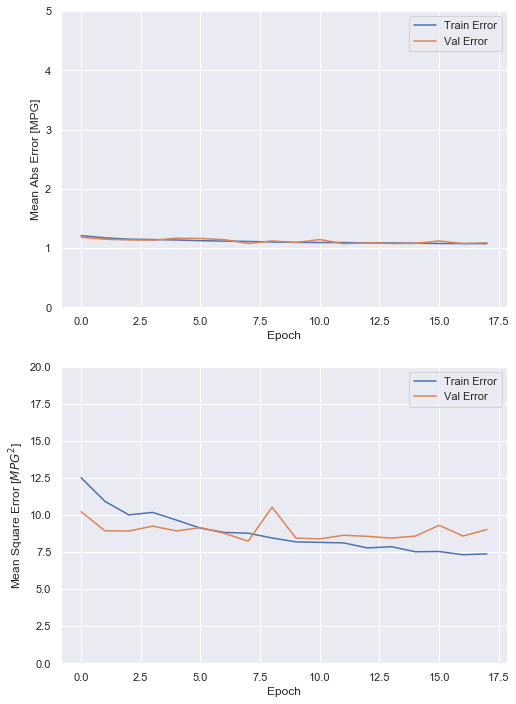

In [29]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

EPOCHS = 1000
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

83085/83085 - 3s - loss: 7.9669 - mae: 1.0694 - mse: 7.9669


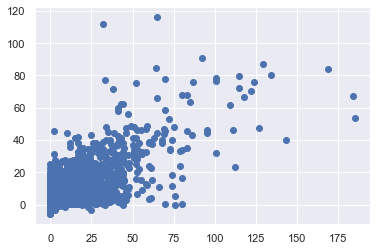

In [31]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)

In [43]:
# rmse를 metrics로 설정하고 싶은 경우 선택합니다.
def rmse(targets, predictions):
  rmse = tf.sqrt(tf.reduce_mean(tf.math.squared_difference(targets, predictions)))
  return rmse

model2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='softmax')
])

model2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [44]:
EPOCHS = 1000
history = model2.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])


...........

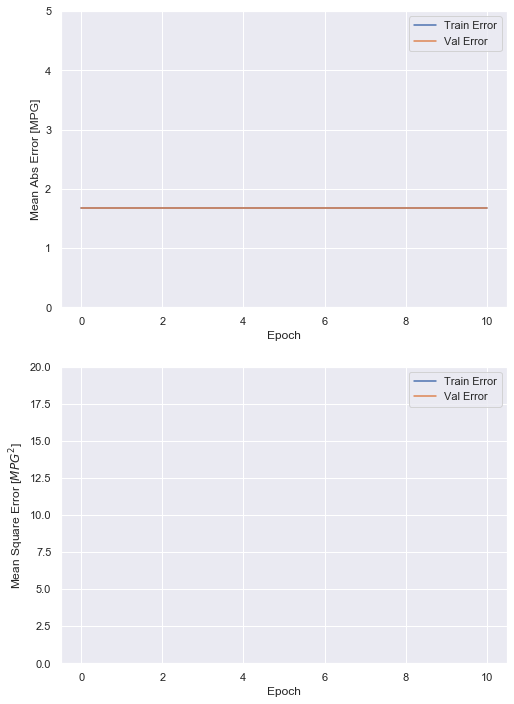

In [45]:
def plot_history2(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['rmse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_rmse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [42]:
loss, mse, rmse = model2.evaluate(normed_test_data, test_labels, verbose=2)

83085/83085 - 3s - loss: 18.7160 - mse: 18.7160 - rmse: 2.8450



............

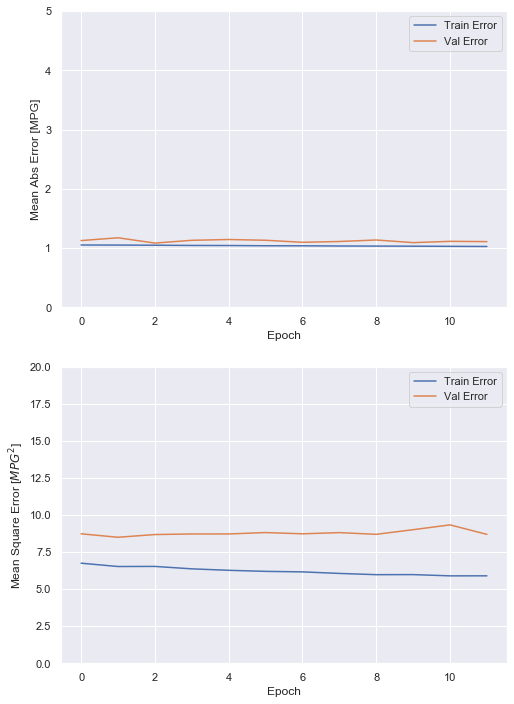

In [47]:
EPOCHS = 1000
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=100,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [48]:
loss, mse, rmse = model.evaluate(normed_test_data, test_labels, verbose=2)

83085/83085 - 3s - loss: 7.8769 - mae: 1.0944 - mse: 7.8769


In [49]:
model3 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model3.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)


.........................

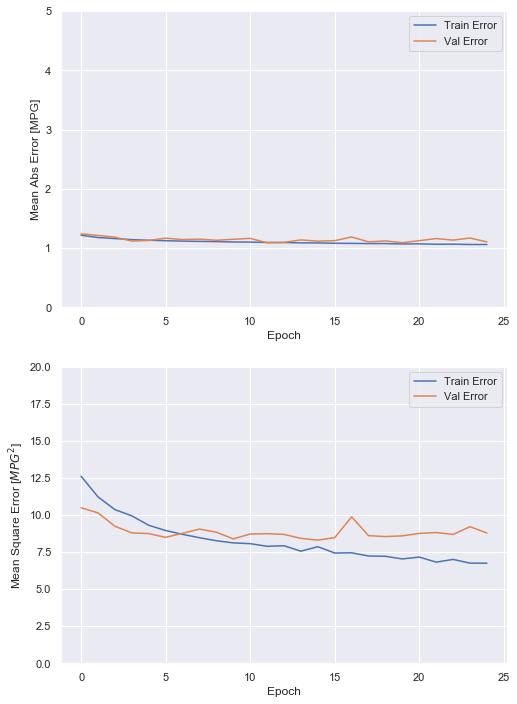

In [50]:
EPOCHS = 1000
history = model3.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=100,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [52]:
loss, mse, rmse = model3.evaluate(normed_test_data, test_labels, verbose=2)

83085/83085 - 3s - loss: 8.2340 - mae: 1.0876 - mse: 8.2340



............

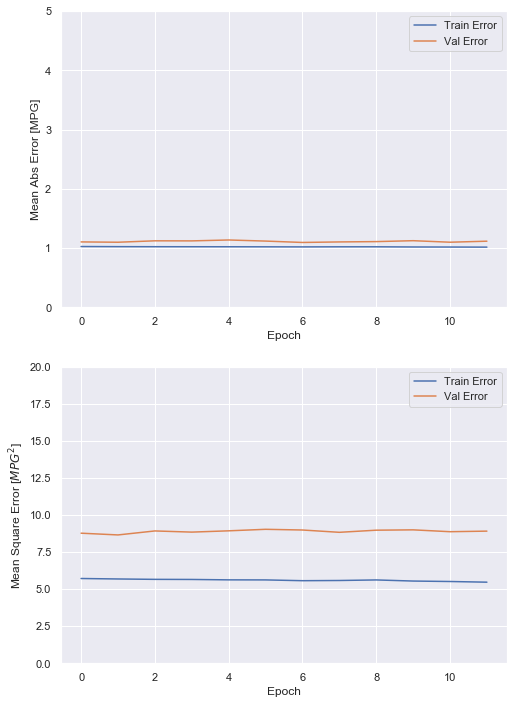

83085/83085 - 4s - loss: 8.1629 - mae: 1.0996 - mse: 8.1629


In [55]:
history = model3.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model3.evaluate(normed_test_data, test_labels, verbose=2)

In [56]:
model4 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model4.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)


...................................

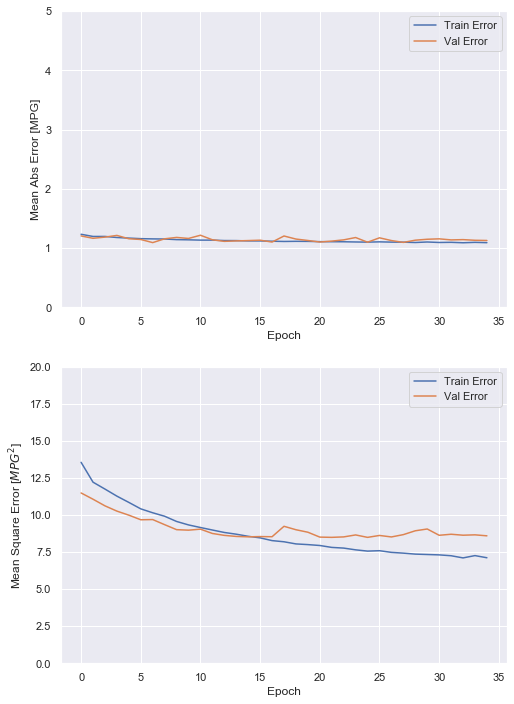

83085/83085 - 4s - loss: 7.9207 - mae: 1.1100 - mse: 7.9207


In [57]:
history = model4.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model4.evaluate(normed_test_data, test_labels, verbose=2)

In [ ]:
history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model.evaluate(normed_test_data, test_labels, verbose=2)

In [27]:
model2 = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)


...............................

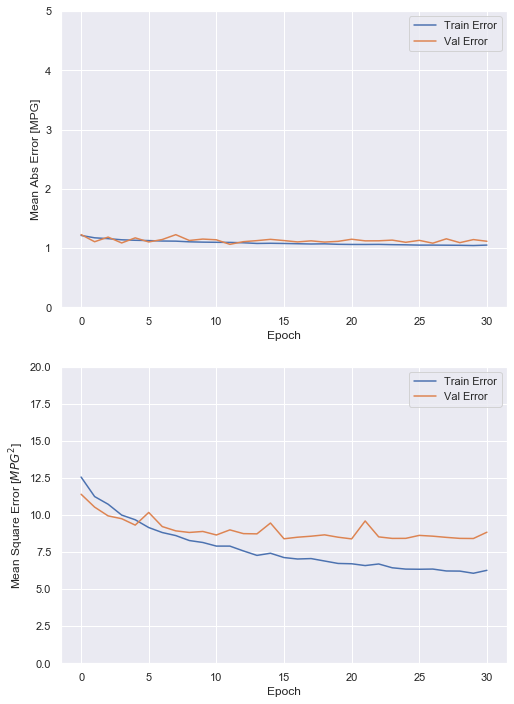

83085/83085 - 3s - loss: 9.2865 - mae: 1.1144 - mse: 9.2865


In [30]:
EPOCHS = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model2.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model2.evaluate(normed_test_data, test_labels, verbose=2)

In [31]:
model2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)


.......................................

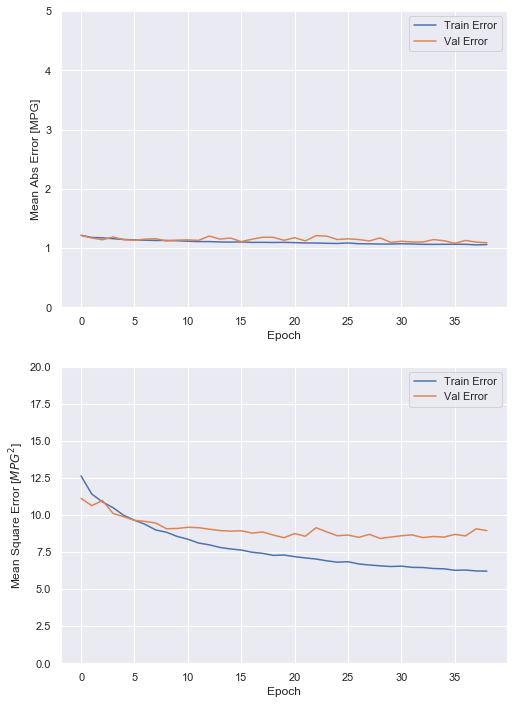

83085/83085 - 4s - loss: 9.5775 - mae: 1.0874 - mse: 9.5775


In [32]:
history = model2.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model2.evaluate(normed_test_data, test_labels, verbose=2)


................................................

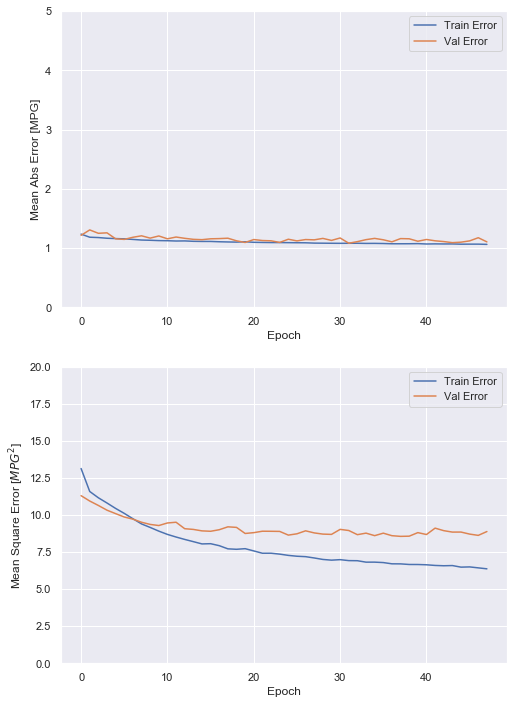

83085/83085 - 4s - loss: 9.1067 - mae: 1.1072 - mse: 9.1067


In [33]:
model2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

history = model2.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model2.evaluate(normed_test_data, test_labels, verbose=2)


.................................

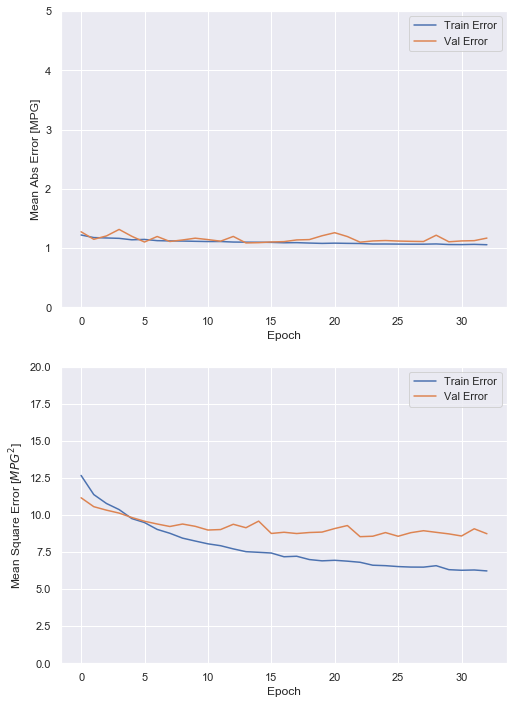

83085/83085 - 3s - loss: 9.1202 - mae: 1.1695 - mse: 9.1203


In [34]:
model2 = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['mae', 'mse']
)

history = model2.fit(normed_train_data, train_labels, epochs=EPOCHS, batch_size=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)
loss, mse, rmse = model2.evaluate(normed_test_data, test_labels, verbose=2)